In [54]:
import os
import sys
home_dir = "../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utility.pickle_utils as pickle_utils

In [59]:
def load_dataset(split = "train"): # train, val, test
    data_path = home_dir+f"data/train_val_test/peaks_with_labels_{split}.tsv.gz"
    data_df = pd.read_csv(data_path, compression="gzip", sep="\t")
    data_df
    return data_df

In [60]:
def compute_label2count(data_df):
    all_labels = []
    def get_all_labels(labels):
        for l in labels.split(","):
            l = l.strip()
            all_labels.append(l)

    data_df["labels"].apply(get_all_labels)
    print(len(all_labels))

    from collections import Counter
    c = Counter(all_labels)  # returns a Counter, dict-like object
    print(len(c))

    label2count_dict = {label:i for label, i in c.items()}
    label2count_df = pd.DataFrame.from_dict(label2count_dict, orient="index")
    label2count_df.reset_index(inplace=True)
    label2count_df.rename(columns={"index":"label", 0:"count"}, inplace=True)
    return label2count_df

In [105]:
def run(split="test"):
    data_df = load_dataset(split)
    label2count_df = compute_label2count(data_df)
    label2count_df.rename(columns={"count":split}, inplace=True)
    return label2count_df
    
    # cellantibody_vs_count_df.rename(columns={"count":split}, inplace=True)
    # return cellantibody_vs_count_df

In [201]:
test_df = run(split="test")
val_df = run(split="val")
train_df = run(split="train")

1550288
690
965103
690
16380384
690


In [202]:
# merging more than 2 dfs
dfs = [train_df, val_df, test_df]
from functools import reduce
merged_df = reduce(lambda  left, right: pd.merge(left, right, on=["label"], how='inner'), dfs)
merged_df

,label,train,val,test
0,wgEncodeAwgTfbsHaibK562Zbtb33Pcr1xUniPk,3458,271,246
1,wgEncodeAwgTfbsSydhH1hescCebpbIggrabUniPk,17187,1101,1719
2,wgEncodeAwgTfbsUtaMcf7CtcfSerumstimUniPk,43298,2687,4675
3,wgEncodeAwgTfbsUwHcpeCtcfUniPk,63352,3650,6412
4,wgEncodeAwgTfbsUtaHelas3CtcfUniPk,36173,2238,3884
...,...,...,...,...
685,wgEncodeAwgTfbsSydhGm12878Znf274UniPk,511,61,40
686,wgEncodeAwgTfbsSydhHelas3Zzz3UniPk,428,17,44
687,wgEncodeAwgTfbsSydhHepg2Znf274UcdUniPk,467,55,32
688,wgEncodeAwgTfbsSydhHelas3Brf2UniPk,359,6,26


In [203]:
from utility.data_utils import get_uniform_peaks_metadata
def add_cellantibody_info(df):
    keep_cols = list(df.columns)
    keep_cols.append("Cell-Antibody")

    peaks_metadata_df = get_uniform_peaks_metadata(home_dir)
    peaks_metadata_df["Cell-Antibody"] = peaks_metadata_df["cell"] + "-" + peaks_metadata_df["antibody"]

    peaks_metadata_df = peaks_metadata_df.merge(df, left_on="tableName", right_on="label", how="inner")
    cellantibody_vs_count_df = peaks_metadata_df[keep_cols].copy()
    cellantibody_vs_count_df.reset_index(inplace=True, drop=True)
    return cellantibody_vs_count_df

In [204]:
merged_df = add_cellantibody_info(merged_df)
merged_df

(690, 18)
Index(['filename', 'project', 'lab', 'composite', 'dataType', 'view', 'cell',
       'treatment', 'antibody', 'control', 'dataVersion', 'dccAccession',
       'controlId', 'quality', 'tableName', 'type', 'md5sum', 'size'],
      dtype='object')


,label,train,val,test,Cell-Antibody
0,wgEncodeAwgTfbsBroadDnd41CtcfUniPk,57715,3373,5099,Dnd41-CTCF
1,wgEncodeAwgTfbsBroadDnd41Ezh239875UniPk,3353,188,320,Dnd41-EZH2_(39875)
2,wgEncodeAwgTfbsBroadGm12878CtcfUniPk,62387,3619,6073,GM12878-CTCF
3,wgEncodeAwgTfbsBroadGm12878Ezh239875UniPk,3407,239,328,GM12878-EZH2_(39875)
4,wgEncodeAwgTfbsBroadH1hescChd1a301218aUniPk,17627,945,1528,H1-hESC-CHD1_(A301-218A)
...,...,...,...,...,...
685,wgEncodeAwgTfbsUwRptecCtcfUniPk,68978,4084,6997,RPTEC-CTCF
686,wgEncodeAwgTfbsUwSaecCtcfUniPk,41712,2391,4192,SAEC-CTCF
687,wgEncodeAwgTfbsUwSknshraCtcfUniPk,38251,2688,3811,SK-N-SH_RA-CTCF
688,wgEncodeAwgTfbsUwWerirb1CtcfUniPk,43160,2454,4397,WERI-Rb-1-CTCF


In [207]:
merged_df["test"].sum()

1550288

In [221]:
merged_df["Test"] = 100*(merged_df["test"] / merged_df["test"].sum())
merged_df["Val"] = 100*(merged_df["val"] / merged_df["val"].sum())
merged_df["Train"] = 100*(merged_df["train"] / merged_df["train"].sum())
merged_df.sort_values(by=["Test"], ascending=True, inplace=True, ignore_index=True)
merged_df

,label,train,val,test,Cell-Antibody,Test,Val,Train
0,wgEncodeAwgTfbsSydhK562Brf1UniPk,262,7,6,K562-BRF1,0.000387,0.000725,0.001599
1,wgEncodeAwgTfbsSydhGm12878Pol3UniPk,245,5,7,GM12878-Pol3,0.000452,0.000518,0.001496
2,wgEncodeAwgTfbsSydhHelas3Brf1UniPk,221,5,7,HeLa-S3-BRF1,0.000452,0.000518,0.001349
3,wgEncodeAwgTfbsSydhK562Bdp1UniPk,599,48,14,K562-BDP1,0.000903,0.004974,0.003657
4,wgEncodeAwgTfbsSydhK562Pol3UniPk,718,20,14,K562-Pol3,0.000903,0.002072,0.004383
...,...,...,...,...,...,...,...,...
685,wgEncodeAwgTfbsHaibGm12878Runx3sc101553V042211...,85728,4758,8363,GM12878-RUNX3_(SC-101553),0.539448,0.493004,0.523358
686,wgEncodeAwgTfbsBroadHelas3CtcfUniPk,77315,4546,8433,HeLa-S3-CTCF,0.543963,0.471038,0.471997
687,wgEncodeAwgTfbsBroadOsteoblCtcfUniPk,84110,4912,8480,Osteobl-CTCF,0.546995,0.508961,0.513480
688,wgEncodeAwgTfbsSydhMcf10aesCfosTam14hHvdUniPk,75734,4137,8594,MCF10A-Er-Src-c-Fos,0.554349,0.428659,0.462346


In [222]:
# how many labels contains 70% of the test data
sum = 0 
for i in range(690, 0):
    sum += merged_df.loc[i, "Test"]
    if sum>=70:
        break
print(i)

257


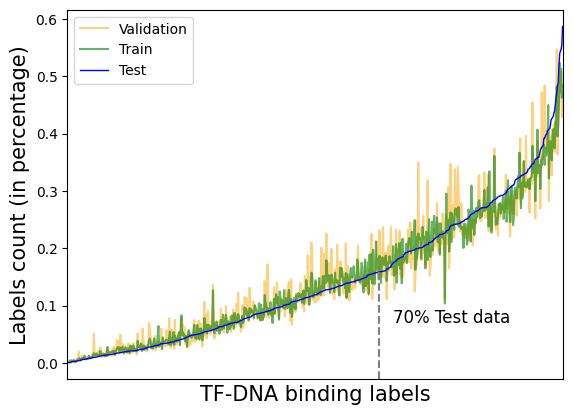

In [237]:
plt.plot(merged_df["Val"], alpha=.5, label="Validation", color="orange")
plt.plot(merged_df["Train"], alpha=.6, label="Train", color="green")
plt.plot(merged_df["Test"], label="Test", linewidth=1, color="blue")

# plt.xticks(range(690), merged_df["Cell-Antibody"], rotation=90, fontsize=2)
plt.xticks([])
plt.xlabel("TF-DNA binding labels", fontsize=15)
plt.ylabel("Labels count (in percentage)", fontsize=15)
plt.xlim(-1, 690)

plt.axvline(x = 690-257, ymax=.3, color='gray', linestyle="--")
plt.text(690-257+20, .07, "70% Test data", fontsize=12)
plt.legend(loc="upper left")
# plt.savefig(home_dir+f"analysis/figures/labels_distribution.png", dpi=300, format="png", bbox_inches='tight', pad_inches=.05)
plt.show()

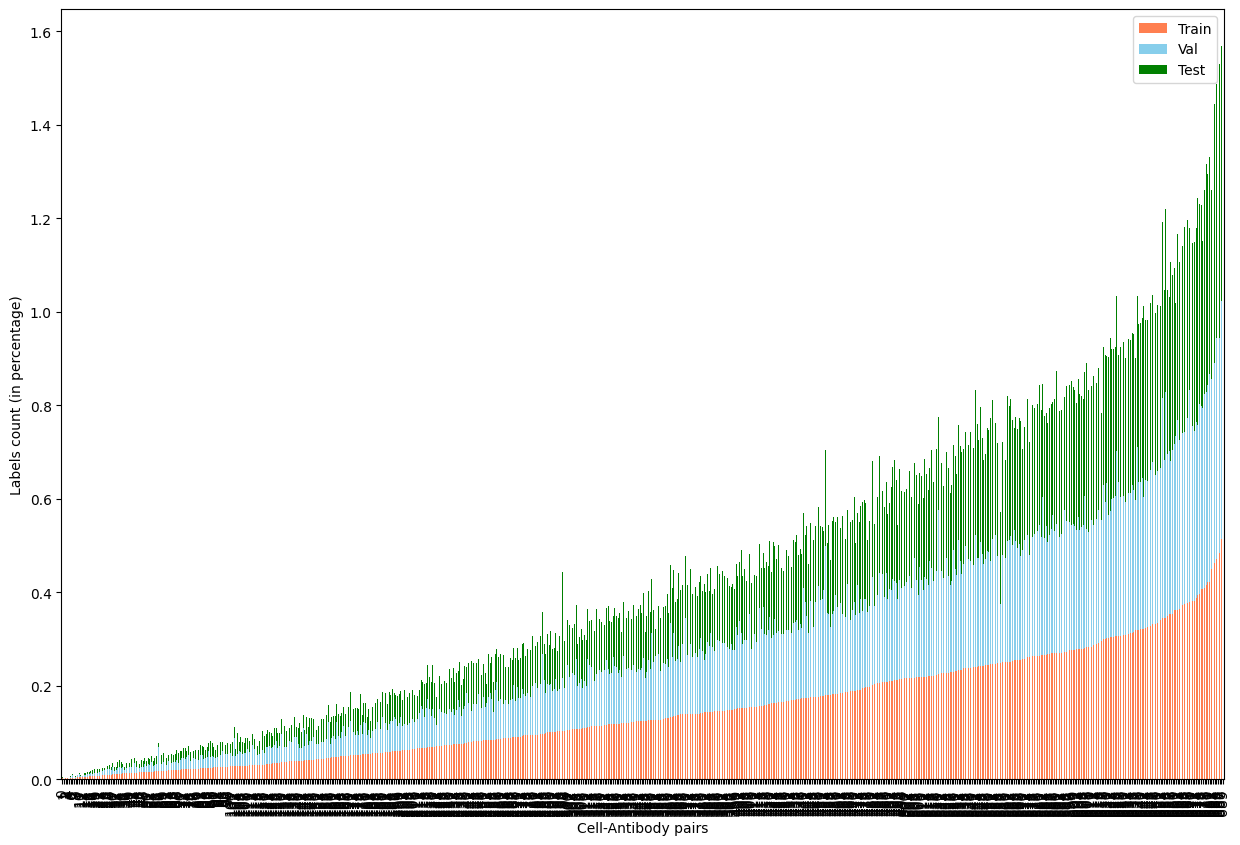

In [200]:
merged_df.sort_values(by=["Train"], inplace=True, ignore_index=True)

# plt.figure()
merged_df[["Train", "Val", "Test"]].plot.bar(stacked=True, color=['coral', 'skyblue', "green"], figsize=(15,10)) #
# merged_df[["Train"]].plot(kind="bar", stacked=True, color=['coral'], figsize=(15,10)) #
# plt.xticks(["Cell-Antibody"], rotation=45, fontsize=2)
plt.xlabel("Cell-Antibody pairs")
plt.ylabel("Labels count (in percentage)")
plt.show()